# Chebyshev and the FFT

We will next explore the interactions between three closely related situations: 

1. Chebyshev series, $x\in [-1,1]$.
2. Fourier series, $\theta\in \mathbb{R}$.
3. Laurent series, $z\in \mathbb{C}$, $|z|=1$. 

The relationships between these variables are straightforward:

$$
z &= e^{i\theta} \\ 
x &= \cos(\theta) \\ 
x &= \operatorname{Re}(z) = \tfrac{1}{2}(z + z^{-1}). 
$$

::::{prf:definition} Chebyshev polynomial
$$
T_n(x) = \tfrac{1}{2}(z^n + z^{-n}) = \cos(n\theta). 
$$
::::

The definition alone does not make it clear that $T_n$ is a polynomial beyond the trivial $T_0(x)=1$ and $T_1(x)=x$. But consider that

$$
\tfrac{1}{2}(z^{n+1} + z^{-n-1})  = \tfrac{1}{2}(z^n + z^{-n}) (z+z^{-1}) - \tfrac{1}{2}(z^{n-1} + z^{-n+1}), 
$$

which proves

$$
T_{n+1}(x) = 2x T_n(x) - T_{n-1}(x), \qquad n=1,2,\dots. 
$$

Therefore, each $T_n$ is a polynomial of degree $n$ with leading coefficient $2^{n-1}$. Each Chebyshev polynomial represents even oscillation around the circle but projects down to oscillations pushed out toward the boundaries of $[-1,1]$:

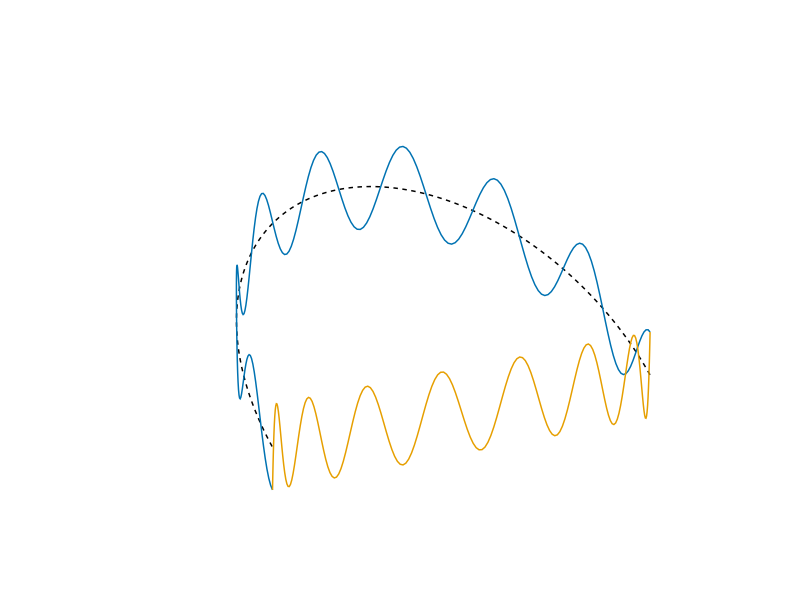

In [1]:
include("smij-functions.jl")
using CairoMakie
fig = Figure(); ax = Axis3(fig[1, 1])
θ = π*(0:200)/200
lines!(cos.(θ),sin.(θ),0*θ,color=:black,linestyle=:dash)
lines!(cos.(θ),sin.(θ),cos.(15θ))
lines!(cos.(θ),0*θ,cos.(15θ))
ax.elevation = 0.2π
ax.azimuth = 1.4π
ax.limits = (-1,1,0,1,-2.5,2.5)
hidedecorations!(ax)
hidespines!(ax)
fig

## Chebyshev series

Any polynomial of degree $N$ can be written as a combination of the first $N+1$ Chebyshev polynomials,

$$
p(x) = \sum_{n=0}^N a_n T_n(x).
$$

Equivalently, we have a **Laurent polynomial**,

$$
\breve{p}(z) = \frac{1}{2} \sum_{n=0}^N a_n (z^n + z^{-n}),
$$

and a trigonometric polynomial,

$$
\tilde{p}(\theta) = \sum_{n=0}^N a_n \cos(n\theta). 
$$

These are all identical:

$$
p(x) = \breve{p}(z) = \tilde{p}(\theta), 
$$

when the three variables are related as we have set out. In the limit $N\to \infty$, each variant becomes an infinite series.

We are interested in using the connections when all the versions of $p$ interpolate a given grid function. In particular, if $p$ interpolates a grid function defined at the Chebyshev points in $x$, then $\tilde{p}(\theta)$ interpolates a grid function around the unit circle, where each of the interior points defines two values:

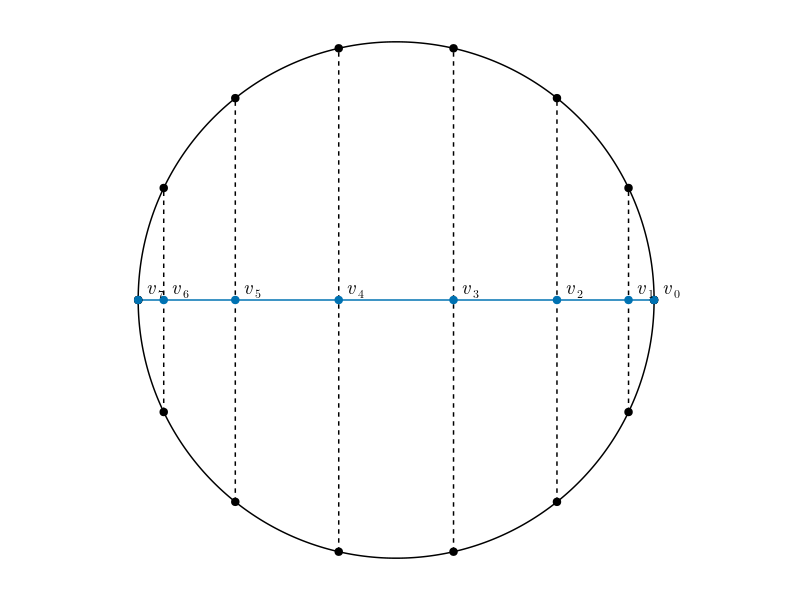

In [2]:
using LaTeXStrings
q = π*(0:800)/400
fig = Figure()
ax = Axis(fig[1, 1], aspect=DataAspect())
lines!(cos.(q),sin.(q),color=:black)
lines!([-1,1],[0,0])
θ = π*(0:7)/7
z = cis.(θ)
x = real(z)
[scatterlines!([x,x],[-imag(z),imag(z)],color=:black,linestyle=:dash) for (x,z) in zip(x,z)]
scatter!(x,0*x)
labels = [ latexstring("v_$j") for j in 0:7 ]
text!(x .+ 0.03, 0*x, text=labels, align=(:left,:bottom) )

hidedecorations!(ax)
hidespines!(ax)
fig

The function $[v_0,v_1,\dots,v_N,v_{N-1},\dots,v_1]$ is even in $\theta$, which is why a cosine series is sufficient for $\tilde{p}$. In fact, the DFT of this function gives us the $a_n$ coefficients directly.

In [3]:
using FFTW
N = 7;
θ = π*(0:N)/N
x = @. cos(θ)
v = @. 2cos(2θ) - 3cos(3θ)
vv = [v; v[N:-1:2]]
fft(vv)/N

14-element Vector{ComplexF64}:
  -3.806478941571965e-16 + 0.0im
   5.075305255429287e-16 + 0.0im
      1.9999999999999996 + 0.0im
     -3.0000000000000004 + 0.0im
   5.075305255429287e-16 + 0.0im
 -1.9032394707859825e-16 + 0.0im
  1.2688263138573217e-16 + 0.0im
                     0.0 + 0.0im
  1.2688263138573217e-16 + 0.0im
 -1.9032394707859825e-16 + 0.0im
   5.075305255429287e-16 + 0.0im
     -3.0000000000000004 + 0.0im
      1.9999999999999996 + 0.0im
   5.075305255429287e-16 + 0.0im

The symmetries in both the data and the transform allow saving space and time by computing only the even (cosine) part by a special syntax. In the case of real data, we use:

In [4]:
FFTW.r2r(v,FFTW.REDFT00) / N

8-element Vector{Float64}:
 -3.806478941571965e-16
  4.440892098500626e-16
  1.9999999999999996
 -3.0
  6.026924990822279e-16
 -2.5376526277146434e-16
  1.2688263138573217e-16
  0.0

## Differentiation

We now have a new algorithmic path for Chebyshev spectral differentiation. By the chain rule,

$$
\frac{dp}{dx} = \frac{d\tilde{p}}{d\theta} \cdot \frac{1}{-\sin(\theta)}. 
$$

At $x=\pm 1$, we have $\sin(\theta)=0$ and need to apply L'Hôpital's rule to get

$$
p'(1) = \sum_{n=0}^N n^2 a_n, \qquad p'(-1) = \sum_{n=0}^N (-1)^{n+1} n^2 a_n.
$$

For the second derivative, one finds

$$
{p}''(x) = \frac{-x}{(1-x^2)^{3/2}} \tilde{p}'(\theta) + \frac{1}{1-x^2}\tilde{p}''(\theta), 
$$

except at the endpoints, where special formulas are needed again.

We use the following code to implement Chebyshev differentiation via the FFT.

```{code-block} julia
function chebfft(v)
    # Simple, not optimal. If v is complex, delete "real" commands.
    N = length(v)-1
    N==0 && return [0.0]
    x = [ cos(π*k/N) for k in 0:N ]
    V = [v; v[N:-1:2]]              # transform x -> theta
    U = real(fft(V))
    W = real(ifft(1im*[0:N-1 ;0; 1-N:-1] .* U))
    w = zeros(N+1)
    @. w[2:N] = -W[2:N]/sqrt(1-x[2:N]^2)    # transform theta -> x
    w[1] = sum( n^2 * U[n+1] for n in 0:N-1 )/N + 0.5N*U[N+1];
    w[N+1] = sum( (-1)^(n+1) * n^2 * U[n+1] for n in 0:N-1 )/N + 0.5N*(-1)^(N+1)*U[N+1];
    return w
end
```

### p18: Chebyshev differentiation via FFT (compare p11)

We reprise a computation done earlier by the differentiation matrix.

In [5]:
u = x -> exp(x) * sin(5x) 
uʹ = x -> exp(x) * (sin(5x) + 5 * cos(5x))
xx = (-200:200) / 200
vv = @. u.(xx)
results = []
for (i,N) in enumerate([10, 20])
    _, x = cheb(N)
    v = u.(x)
    error = chebfft(v) - uʹ.(x)
    ee = polyinterp(x, error).(xx)
    push!(results, (;x,v,error,ee))
end

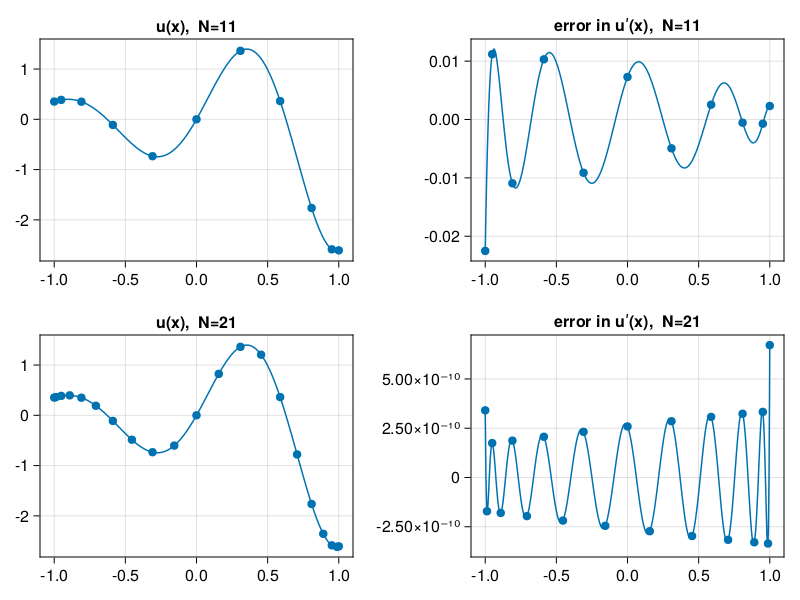

In [6]:
using CairoMakie
fig = Figure()
for (i,r) in enumerate(results)
    N = length(r.x)
    Axis(fig[i, 1], title="u(x),  N=$N")
    scatter!(r.x, r.v)
    lines!(xx, vv)
    Axis(fig[i, 2], title="error in uʹ(x),  N=$N")
    scatter!(r.x, r.error)
    lines!(xx, r.ee)
end
fig

### p19: 2nd-order wave eq. on Chebyshev grid (compare p6)

We can solve the wave equation $\partial_{tt} u = \partial_{xx} u$ directly as a 2nd-order equation through discretization of the time derivative as a 2nd-order centered difference:

$$
\frac{\bfu_{j-1} - 2\bfu_j +  \bfu_{j+1}}{\tau^2} = \bfD_{xx} \bfu_j,
$$

which rearranges to

$$
\bfu_{j+1} = 2\bfu_j - \bfu_{j-1} + \tau^2 (\bfD_{xx} \bfu_j).
$$

Even though we have apparently used a differentiation matrix above, we can always replace its application to a vector by the FFT process. We're being lazy and wasteful here by just applying `chebfft` twice in a row, rather than properly coding the second derivative directly.

In [7]:
# Time-stepping by leap frog formula:
N = 80
_, x = cheb(N)
Δt = 8 / N^2
v = @. exp(-200 * x^2)
vold = @. exp(-200 * (x - Δt)^2)

tmax = 4
nsteps = ceil(Int, tmax / Δt)
Δt = tmax / nsteps
V = [v fill(NaN, N+1, nsteps)]
t = Δt*(0:nsteps)
for i in 1:nsteps
    w = chebfft(chebfft(V[:,i]))
    w[1] = w[N+1] = 0
    V[:,i+1] = 2V[:,i] - vold + Δt^2 * w
    vold = V[:,i]
    if norm(V[:,i+1], Inf) > 2.5
        nsteps = i
        break 
    end
end

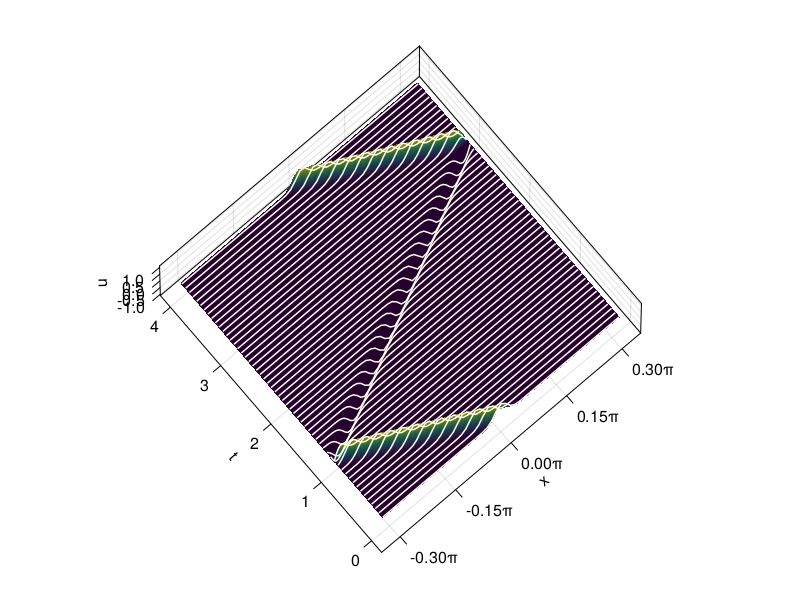

In [8]:
using PyFormattedStrings
# Plot results:
fig = Figure()
Axis3(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="t", zlabel="u", 
    elevation=1.44,
)
gap = max(1,round(Int, 0.075/(t[2]-t[1])) - 1)
surface!(x, t, V, colorrange=(0,1))
[ lines!(x, fill(t[j], length(x)), V[:, j].+.01, color=:ivory) for j in 1:gap:size(V,2) ]
fig

In [9]:
fig = Figure(size=(480,360))
index = Observable(1)
ax = Axis(fig[1, 1],xlabel="x", ylabel="u" )
lines!(x, @lift(V[:,$index]))
record(fig, "p19.mp4", 1:10:size(V,2)+1) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
    limits!(-1,1,-1,1)
end;

<video autoplay controls><source src="p19.mp4" type="video/mp4"></video>


### p20: 2nd-order wave eq. in 2D via FFT (compare p19)

The 2D wave equation is analogously solved via 

$$
\bfu_{j+1} = 2\bfu_j - \bfu_{j-1} + \tau^2 (\bfD_{xx} \bfu_j + \bfD_{yy} \bfu_j).
$$

It's simplest to maintain the unknown $\bfu$ as a matrix-shaped grid function. Then we can apply `chebfft` to each column of data for the $x$ derivatives, and to each row of data for the $y$ derivatives. To make smooth plots, we also use a grid interpolation function to a finer grid.

In [10]:
# Grid and initial data:
N = 36
x = y = cheb(N)[2]
Δt = 6 / N^2
xx = yy = range(-1,1,81)
nsteps = ceil(Int, 1 / Δt)
Δt = 1 / nsteps

vv = [exp(-40 * ((x - 0.4)^2 + y^2)) for x in x, y in y]
vvold = vv

t = Δt*(0:nsteps)
V = zeros(length(xx),length(yy),nsteps+1)
V[:,:,1] = gridinterp(vv,xx,yy)

# Time-stepping by leap frog formula:
uxx = zeros(N+1, N+1)
uyy = zeros(N+1, N+1)
for n in 1:nsteps
    ii = 2:N
    for i in 2:N
        uxx[i,:] .= chebfft(chebfft(vv[i,:]))
        uyy[:,i] .= chebfft(chebfft(vv[:,i]))
    end
    uxx[[1,N+1],:] .= uyy[[1,N+1],:] .= 0
    uxx[:,[1,N+1]] .= uyy[:,[1,N+1]] .= 0
    vvnew = 2vv - vvold + Δt^2 * (uxx + uyy)
    vvold,vv = vv,vvnew
    V[:,:,n+1] = gridinterp(vv,xx,yy)
end

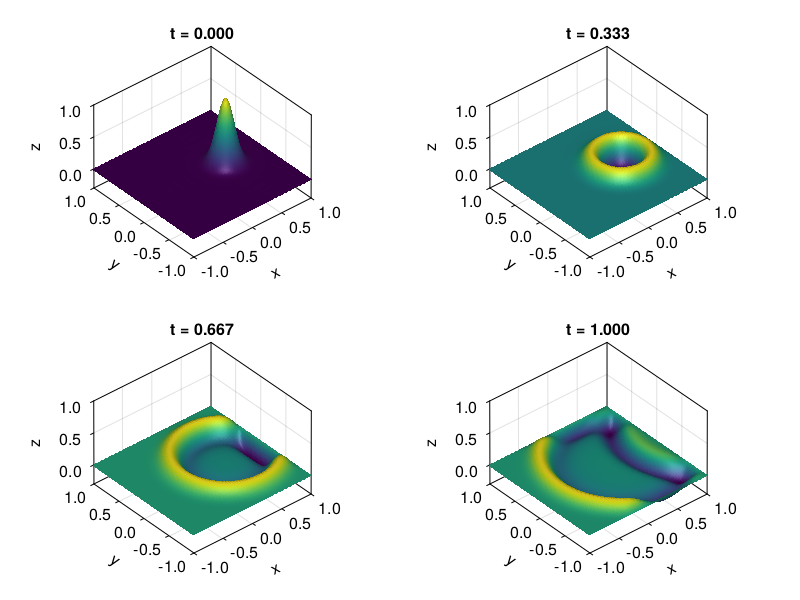

In [11]:
inc = div(nsteps,3)
fig = Figure()
ax = [ Axis3(fig[j,i], zticks=[0,0.5,1]) for i in 1:2, j in 1:2 ]
for (i,n) in enumerate(1:inc:nsteps+1) 
    surface!(ax[i],xx,yy,V[:,:,n])
    ax[i].title = f"t = {t[n]:.3f}"
    limits!(ax[i],-1,1,-1,1,-0.3,1)
    ax[i].elevation = π/5
end
fig

In [12]:
fig = Figure(size=(480,320))
index = Observable(1)
# ax = Axis(fig[1, 1], xlabel="x", ylabel="y", aspect=DataAspect())
ax = Axis3(fig[1, 1], xlabel="x", ylabel="y", azimuth=-π/2, elevation=π/2)
# co = contourf!(ax,xx, yy, @lift(V[:,:,$index]), 
#     levels=range(-0.3,1,24),
#     colormap=:bluesreds )
co = surface!(xx, yy, @lift(V[:,:,$index]), 
        colormap=:bluesreds, colorrange=[-0.8,0.8] )
record(fig, "p20.mp4", 1:size(V,3)) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
end;

<video autoplay controls><source src="p20.mp4" type="video/mp4"></video>